In [154]:
import os
import numpy as np
import torch
from PIL import Image
import sys
sys.path.append('/Users/Ann/Documents/DS2-final')

from floortrans.loaders.house import House
import copy
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import model_utils.transforms as T
from model_utils.engine import train_one_epoch, evaluate
import model_utils.utils as utils
import matplotlib.pyplot as plt

from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, discrete_cmap
discrete_cmap()
from collections import defaultdict
import cv2
from floortrans.metrics import get_evaluation_tensors, runningScore


In [20]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
rooms = ["Outdoor", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
room_ids = [1,3,4,5,6,7,8,9,10,11]
room_labels = {rooms[i]:i+1 for i in range(len(rooms))}

In [21]:
class CubicasaDataset(object):
    def __init__(self, root, mode, transforms=None):
        self.root = root
        #self.dict = torch.load(f"data/cubicasa5k/instance_info_{mode}.pt")
        self.transforms = transforms
        self.imgs = np.genfromtxt(root + '/'+mode+'.txt', dtype='str')
    
        
    def __getitem__(self, idx):
   
        org_img_path = self.root + self.imgs[idx]+'F1_original.png'
        img_path = self.root + self.imgs[idx]+'F1_scaled.png'
        svg_path = self.root + self.imgs[idx]+'model.svg'        

        height, width, _ = cv2.imread(img_path).shape
        height_org, width_org, _ = cv2.imread(org_img_path).shape

        # Getting labels for segmentation and heatmaps
        house = House(svg_path, height, width)
        # Combining them to one numpy tensor
        label = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

        label = label.unsqueeze(0)
        label = torch.nn.functional.interpolate(label,
                                                    size=(height_org, width_org),
                                                    mode='nearest')
        label = label.squeeze(0)[0]


        #############process items##############
        masks = cv2.resize(label.data.numpy(), (256,256))
    
        boxes = []
        labels = []
        num_obj = 0
        
        mask_tensor = []
        areas = []

        limit_list = []

        for r in room_ids:
            x = copy.copy(masks)
            x[masks != r] = 0 
            x = x.astype(np.uint8)
            contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            limit_list +=[(r, cot) for cot in contours]
            num_obj+=len(contours)
        
#         if num_obj >20:
#             rand_inds = np.random.choice(np.arange(num_obj), 20, replace  = False)
        if num_obj ==0:
            rand_inds = []
            print('No objects in this image, folder:', self.imgs[idx])
        else:
            rand_inds = np.arange(num_obj)
        
        for ind in rand_inds:
            r, tcnt = limit_list[ind]
            im = np.zeros((256,256,3), np.uint8)
            im = cv2.drawContours(im, [tcnt], -1, (255,255,255), -1)
            mask_tensor.append((im[:,:,0]/255).astype(np.int8))
            areas.append(cv2.contourArea(tcnt,False))
            x,y,w,h = cv2.boundingRect(tcnt)
            boxes.append([x,y,x+w,y+h])
            labels.append(room_labels[room_classes[r]])
        
        boxes = torch.FloatTensor(boxes)
        labels = torch.as_tensor(labels, dtype = torch.long)
        areas = torch.FloatTensor(areas)
        
        try:
            mask_tensor = np.stack(mask_tensor, 0)
        except:
            mask_tensor = np.array([])


        #######################################
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = torch.as_tensor(mask_tensor, dtype=torch.uint8)
        target["image_id"] = torch.tensor([idx], dtype = torch.int8)
        #target["folder"] = torch.tensor([self.imgs[idx]])
        target["area"] = areas
        target["iscrowd"] = torch.zeros(num_obj, dtype = torch.int8)
        
        img = Image.open(org_img_path).convert("RGB")
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [22]:

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model
def get_transform(train):
    transforms = []
    transforms.append(T.Resize((256,256)))
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [25]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1+10
# use our dataset and defined transformations
dataset = CubicasaDataset('../data/cubicasa5k', 'train',get_transform(train=True))

dataset_test = CubicasaDataset('../data/cubicasa5k', 'val',get_transform(train=False))

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=False, 
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, 
        collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)


    

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

# check models

In [27]:
model.load_state_dict(torch.load('../models/maskrcnn_4_resized.pt',map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [145]:

class Decode_Maskrcnn(object):
    
    def __init__(self, dataset, idx, model = None, prediction = None, nms = 0.9):
        
        self.folder = dataset.imgs[idx]
        self.img = dataset[idx][0]
        
        if not prediction:
            model.eval()
            with torch.no_grad():
                self.pred = model([self.img])[0]
        else:
            self.pred = prediction[0]
        
        
        self.org_img_path ='../data/cubicasa5k'+self.folder+'F1_original.png'
        self.height_org, self.width_org, _ = cv2.imread(self.org_img_path).shape
        
        self.inds = torchvision.ops.nms(self.pred['boxes'], self.pred['scores'],nms)

    
    ##################GROUND TRUTH####################
    
    def get_groundtruth(self, img_show = True, resize= False):
        
        svg_path ='../data/cubicasa5k'+self.folder+'model.svg'
        img_path ='../data/cubicasa5k'+self.folder+'F1_scaled.png'
        height, width, _ = cv2.imread(img_path).shape
        

        house = House(svg_path, height, width)
        # Combining them to one numpy tensor
        gt = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

        gt = gt.unsqueeze(0)
        gt = torch.nn.functional.interpolate(gt,size=(self.height_org, self.width_org),
                                                            mode='nearest')
        gt = gt.squeeze(0)[0]
        
        if resize:
            gt = cv2.resize(gt.data.numpy(), (256,256)) #return numpy array

        if img_show:
            plt.figure(figsize=(10,10))
            ax = plt.subplot(1, 1, 1)
            plt.title('Ground Truth Rooms and walls', fontsize=20)
            ax.axis('off')
            n_rooms = 12
            rseg = ax.imshow(gt, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
            cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
            cbar.ax.set_yticklabels(room_classes, fontsize=20)
            plt.show()
        
        return gt
    
    
    ##################PREDICTION#######################

    #segmentation map
    def get_segmap(self, thres = 0.1, img_show = True, resize= False):
        
        num,_, H,W =self.pred['masks'].shape

        seg_map = torch.zeros((H,W))
        labels = set()
        for i in self.inds:
            label = int(self.pred['labels'][i].data.numpy())
            if label>=2:
                label+=1
            if label in labels:
                continue
            mask = self.pred['masks'][i,0,:,:]
            #edges = torch.zeros(mask.shape)
            #edges[mask>thres] = 1
            #walls = torch.as_tensor(getBordered(edges.data.numpy(), 4))
            #seg_map[walls==1] = 2
            seg_map[mask>thres] = label
            labels.add(label)
            
#         edges = torch.as_tensor(self.getBordered(seg_map.data.numpy(), 4))
#         seg_map[edges == 1] = 2
        seg_map = seg_map.data.numpy()
        edges = cv2.Canny(seg_map.astype(np.uint8), 0.1,0.2)
        kernel = np.ones((5,5), dtype = np.uint8)
        erosion = cv2.erode(edges,kernel,iterations = 1)
        dilation = cv2.dilate(edges,kernel,iterations = 1)
        seg_map[dilation != 0] = 2
        
        #resize
        if not resize:
            #return numpy array
            seg_map = cv2.resize(seg_map,(self.width_org, self.height_org) )
        
        if img_show:
            plt.figure(figsize=(10,10))
            ax = plt.subplot(1, 1, 1)
            plt.title('Predicted Rooms and walls', fontsize=20)
            ax.axis('off')
            n_rooms = 12
            rseg = ax.imshow(seg_map, cmap = 'rooms', vmin=0, vmax=n_rooms-0.1)
            cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms)+0.3, fraction=0.046, pad=0.01)
            cbar.ax.set_yticklabels(room_classes, fontsize=20)
            plt.show()
            
        

        return seg_map

    
    
    #room detection 
    def room_detect(self, class_id, img_show = True):
        
        self.results = {}

        for i in range(1,11):
            self.results[i] = defaultdict(list)

        for i,lab in enumerate(self.pred['labels'][self.inds]):
            lab = int(lab.data.numpy())
            self.results[lab]['boxes'].append(self.pred['boxes'][i])

        image = cv2.imread(self.org_img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
        if len(self.results[class_id]['boxes'])!= 0:
        
            for (x,y,z,w) in self.results[class_id]['boxes']:
                
                scale_x, scale_y = self.width_org/256, self.height_org/256
                new_x, new_z = x*scale_x, z*scale_x
                new_y, new_w = y*scale_y, w*scale_y


                image = cv2.rectangle(image, (new_x,new_y), (new_z,new_w), (0,252,0), 3) 

            result = image
            result = cv2.resize(result, (self.width_org, self.height_org))

            if img_show:
                plt.figure(figsize = (20,12))
                plt.imshow(result)
                plt.title(rooms[class_id-1], fontsize = 20)
        
        else:
            print('No such object')
            result = None
        
        return result
    
    
    def collect_result(self, thres = 0.1, img_show = True):
    
        
        seg_map =self.get_segmap(thres = thres, img_show =False) #.data.numpy()
        
        result = cv2.imread(self.org_img_path)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        
        for i in range(1,11):
            
            pix = i+1 if i>=2 else i
            m = copy.copy(seg_map)
            m[seg_map!= pix] = 0 
            m = m.astype(np.uint8)

            contours, _ = cv2.findContours(m,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            for tcnt in contours: 

                x,y,w,h = cv2.boundingRect(tcnt)
                result = cv2.rectangle(result, (x,y), (x+w,y+h), (0,252,0), 3) 
            result = cv2.putText(result, rooms[i-1], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (252,0,0), 2)

        
        #result = cv2.UMat.get(result)
       
        if img_show:
            plt.figure(figsize = (20,12))
            plt.imshow(result)
            plt.title('Predict Result collection', fontsize = 20)

        return result
    
    
    def getBordered(self, image, width):
        bg = np.zeros(image.shape)
        img = image.copy().astype(np.uint8)
        contours, _ = cv2.findContours(img, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        biggest = 0
        bigcontour = None
        for contour in contours:
            area = cv2.contourArea(contour) 
            if area > biggest:
                biggest = area
                bigcontour = contour
        return cv2.drawContours(bg, [bigcontour], 0, (255, 255, 255), width).astype(bool)

    

In [146]:
dm = Decode_Maskrcnn(dataset_test, 0, model, nms = 1)

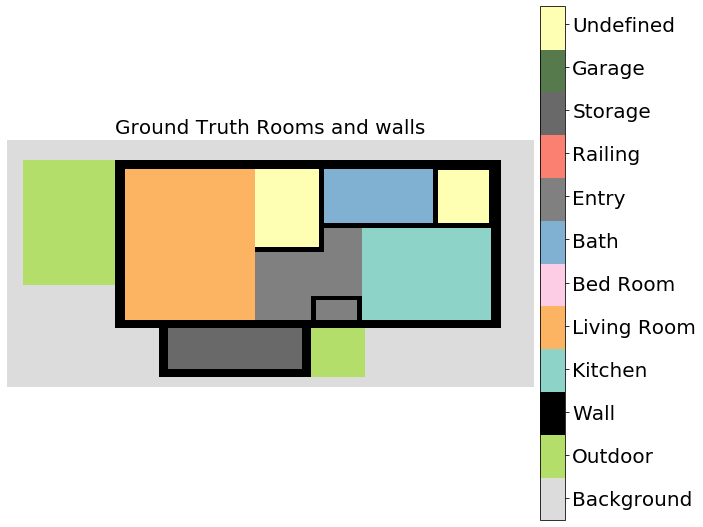

In [147]:
gt = dm.get_groundtruth()

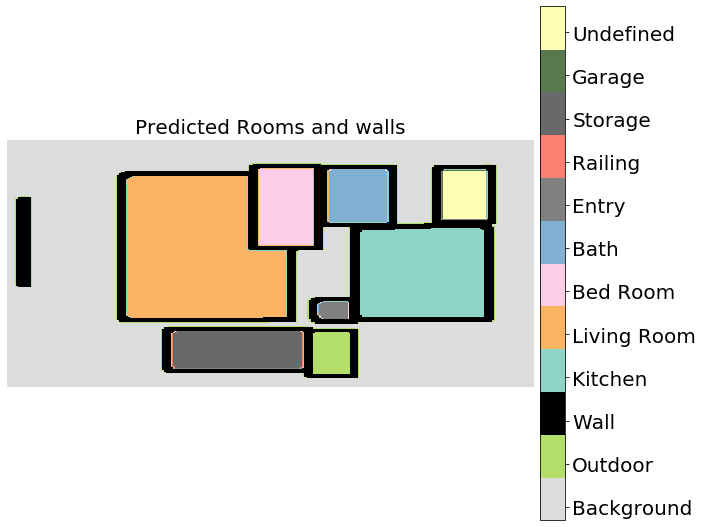

In [148]:
seg_map =  dm.get_segmap(0.1)

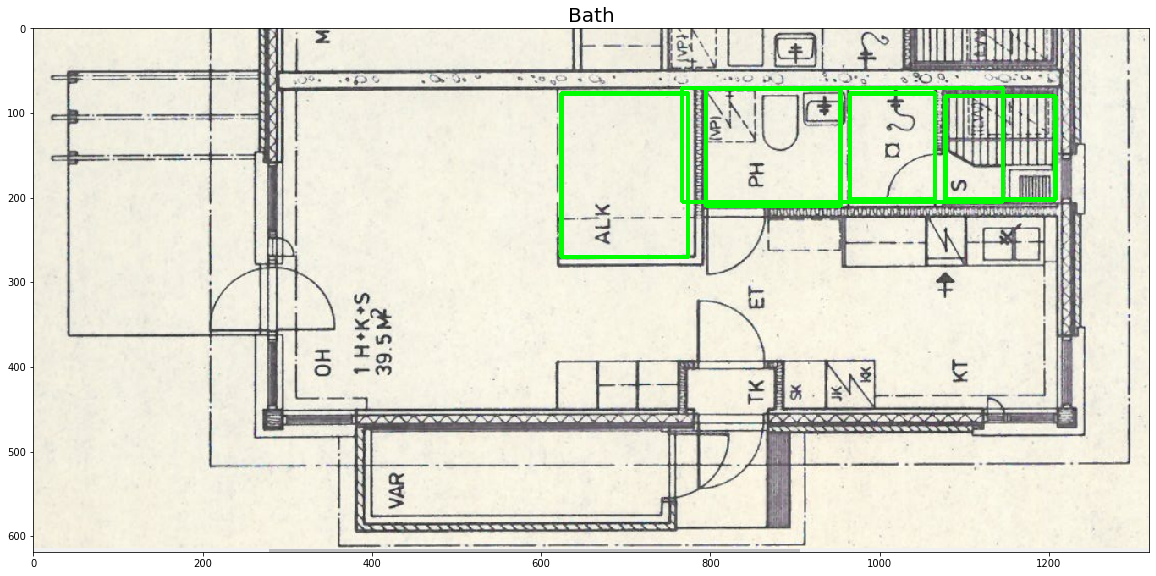

In [139]:
bed_room =  dm.room_detect(room_labels['Bath'])

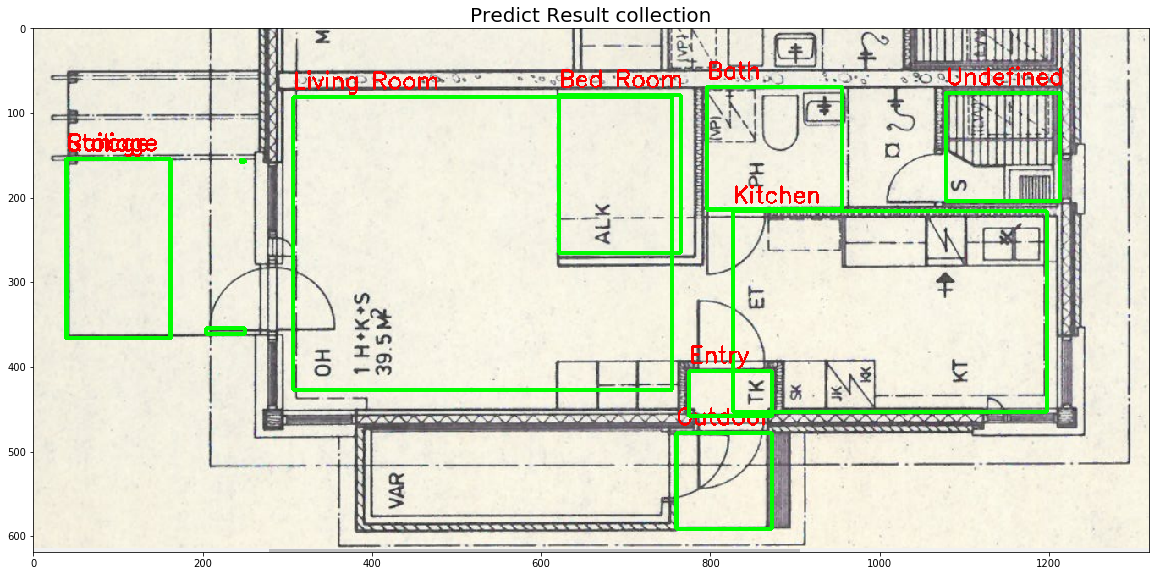

In [140]:
rc = dm.collect_result()

# Check evaluation

In [39]:
# dataset_val = CubicasaDataset('data/cubicasa5k', 'val',get_transform(train=False))

# data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False, 
#             collate_fn=utils.collate_fn)
# evaluate(model, data_loader_val, device=device)

In [40]:
# for epoch in range(1,4):
#     model.load_state_dict(torch.load(f'models/maskrcnn_{epoch}.pt',map_location='cpu'))
#     evaluate(model, data_loader_val, device=device)

# Check folder (debug)

In [17]:
def check_folder(folder_name, img_show = True):
    
        
    svg_path ='./data/cubicasa5k'+folder_name+'model.svg'
    img_path ='./data/cubicasa5k'+folder_name+'F1_scaled.png'
    org_img_path ='./data/cubicasa5k'+folder_name+'F1_original.png'
    height, width, _ = cv2.imread(img_path).shape
    height_org, width_org, _ = cv2.imread(org_img_path).shape

    house = House(svg_path, height, width)
    # Combining them to one numpy tensor
    gt = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

    gt = gt.unsqueeze(0)
    gt = torch.nn.functional.interpolate(gt,size=(height_org, width_org),
                                                            mode='nearest')
    gt = gt.squeeze(0)[0]

    if img_show:
        plt.figure(figsize=(10,10))
        ax = plt.subplot(1, 1, 1)
        plt.title('Ground Truth:'+folder_name, fontsize=20)
        ax.axis('off')
        n_rooms = 12
        rseg = ax.imshow(gt, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
        cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(room_classes, fontsize=20)
        plt.show()
        
        
    return gt

# check files

In [58]:
idx = 0
img = dataset_test[idx][0]
folder = dataset_test.imgs[idx]
org_path = './data/cubicasa5k'+folder+'F1_original.png'
# model.eval()
# with torch.no_grad():
#     prediction = model([img])[0]

In [59]:
boxes = prediction['boxes']

In [60]:
box = torchvision.ops.nms(prediction['boxes'], prediction['scores'], 0.2)

In [274]:
prediction['scores']

tensor([0.8583, 0.8104, 0.7879, 0.7780, 0.7373, 0.6675, 0.5594, 0.5490, 0.5171,
        0.4194, 0.4076, 0.3965, 0.3836, 0.3592, 0.3560, 0.3497, 0.3475, 0.3280,
        0.3264, 0.3043, 0.2813, 0.2764, 0.2744, 0.2715, 0.2654, 0.2585, 0.2423,
        0.2419, 0.2340, 0.2339, 0.2301, 0.2106, 0.2011, 0.1972, 0.1895, 0.1884,
        0.1769, 0.1758, 0.1643, 0.1568, 0.1565, 0.1456, 0.1439, 0.1424, 0.1396,
        0.1394, 0.1309, 0.1291, 0.1270, 0.1259, 0.1227, 0.1192, 0.1183, 0.1152,
        0.1136, 0.1124, 0.1109, 0.1058, 0.0948, 0.0937, 0.0917, 0.0904, 0.0808,
        0.0804, 0.0770, 0.0765, 0.0760, 0.0722, 0.0718, 0.0713, 0.0708, 0.0698,
        0.0692, 0.0663, 0.0655, 0.0635, 0.0623, 0.0577, 0.0540, 0.0540, 0.0530,
        0.0519, 0.0515, 0.0509, 0.0500])

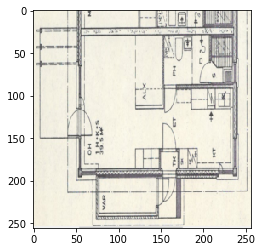

In [67]:
image = np.moveaxis(img.data.numpy(),0,-1)
plt.imshow(image)

# Evaluation

In [149]:
evaluator = runningScore(12)


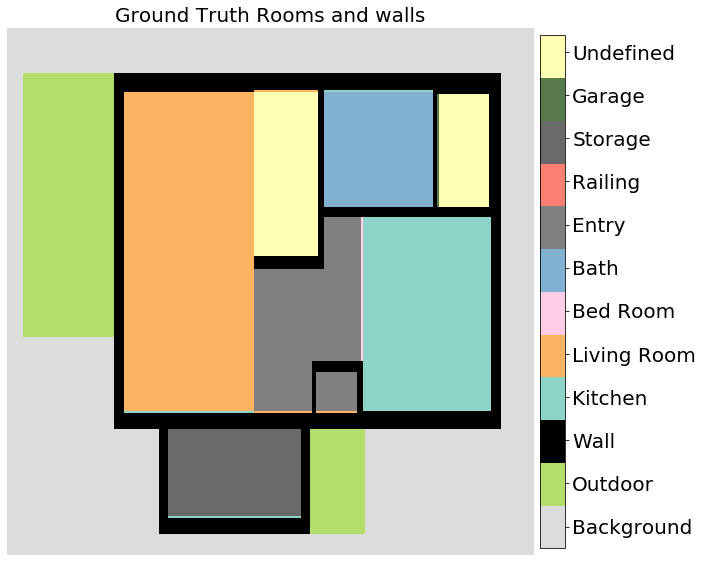

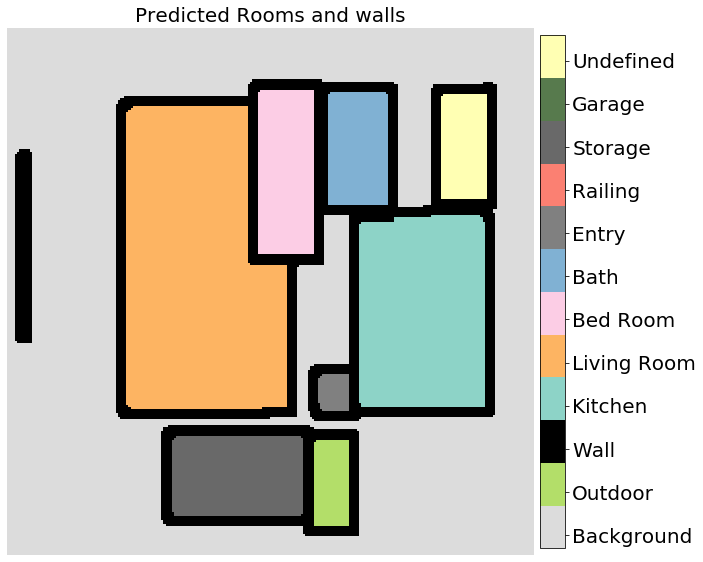

In [150]:
seg_gt = torch.as_tensor(dm.get_groundtruth(resize = True))
seg_pred = torch.as_tensor(dm.get_segmap(0.1, resize = True))
evaluator.update(seg_gt,seg_pred )

In [152]:
model.load_state_dict(torch.load('../models/maskrcnn_4_resized.pt',map_location='cpu'))
from tqdm import tqdm_notebook as tqdm

for idx in tqdm(range(len(dataset_test))):
    
    dm = Decode_Maskrcnn(dataset_test, idx, model, nms = 1)
    
    seg_gt = torch.as_tensor(dm.get_groundtruth(resize = True, img_show = False))
    seg_pred = torch.as_tensor(dm.get_segmap(0.1, resize = True, img_show = False))
    evaluator.update(seg_gt,seg_pred)



In [153]:
evaluator.get_scores()

({'Overall Acc': 0.6657329759098348,
  'Mean Acc': 0.4932519217537179,
  'FreqW Acc': 0.49457703598712405,
  'Mean IoU': 0.36085322449837004},
 {'Class IoU': {'0': 0.6817120486474212,
   '1': 0.36543292599763105,
   '2': 0.30884701763951294,
   '3': 0.5776927815673304,
   '4': 0.6046938126066258,
   '5': 0.4154232095780929,
   '6': 0.41005940493302634,
   '7': 0.37667028046609197,
   '8': 0.021647083336433923,
   '9': 0.270313051736944,
   '10': 0.20527611993959877,
   '11': 0.09247095753173111},
  'Class Acc': {'0': 0.942467643308625,
   '1': 0.4163342413643031,
   '2': 0.5457671209687295,
   '3': 0.683437004595587,
   '4': 0.7785559765265511,
   '5': 0.487243168734644,
   '6': 0.5136519092682913,
   '7': 0.5059262840117599,
   '8': 0.0321308650702483,
   '9': 0.37568809668287234,
   '10': 0.5360173867327588,
   '11': 0.10180336378024454}})

In [157]:
evaluator = runningScore(12)
dataset_test = CubicasaDataset('../data/cubicasa5k', 'test',get_transform(train=False))
for idx in tqdm(range(len(dataset_test))):
    
    dm = Decode_Maskrcnn(dataset_test, idx, model, nms = 1)
    
    seg_gt = torch.as_tensor(dm.get_groundtruth(resize = True, img_show = False))
    seg_pred = torch.as_tensor(dm.get_segmap(0.1, resize = True, img_show = False))
    evaluator.update(seg_gt,seg_pred)

In [158]:
evaluator.get_scores()

({'Overall Acc': 0.6452921575038277,
  'Mean Acc': 0.47102841564820763,
  'FreqW Acc': 0.4712432547043605,
  'Mean IoU': 0.3376438498334861},
 {'Class IoU': {'0': 0.6636616404691466,
   '1': 0.3717517288386513,
   '2': 0.3008028135893076,
   '3': 0.5251514534239221,
   '4': 0.5824416195391118,
   '5': 0.35061137355532357,
   '6': 0.4101838442819159,
   '7': 0.36870694193699993,
   '8': 0.023016182914660073,
   '9': 0.22469668490946546,
   '10': 0.15684199835375476,
   '11': 0.07385991618957405},
  'Class Acc': {'0': 0.9346946385599587,
   '1': 0.42663143327973174,
   '2': 0.5291152898276201,
   '3': 0.6309184903451125,
   '4': 0.7583179655812707,
   '5': 0.420599513772275,
   '6': 0.5091078102592086,
   '7': 0.49702669527103926,
   '8': 0.0352195273081349,
   '9': 0.32217983369327663,
   '10': 0.506947710881154,
   '11': 0.08158207899970994}})